# Separate events in predictions

01.09.2022

Uso questo script per separare gli eventi nelle predictions, così da poter poi calcolare le metrics sulla instance segmentation.

Due idee:
- prima separare le classi e poi gli eventi
- sommare le preds delle classi, separare gli eventi e poi separare le classi

Una volta fatto, includere le funzioni in uno script normale di Python (.py) e usarle per la validation dei modelli (magari anche durante il training). A quel punto si potrà eliminare questo notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import os
import imageio
import napari
import matplotlib.pyplot as plt

import cc3d
import skimage
from scipy import ndimage as ndi

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

## Load predictions

Load predictions from files generated when running the test function during training.

They are saved in `runs\<training_name>\predictions` and the filename template is `<training_name>_<movie_id>_<preds class/xs/ys/...>.tif`.

The epoch is not explicitly mentionned, but it depends on the last epoch of the last model that has been run.

In [4]:
# assuming these are the number IDs whose predictions are available...
movie_ids = ["05","10","15","20","25","32","34","40","45"]

### Select training name to load

In [5]:
training_name = 'TEMP_new_annotated_peaks_physio'

### Configure input & output directory

In [6]:
data_dir = os.path.join("runs", training_name, "predictions")
out_dir = "trainings_validation"

### Load movies

In [7]:
xs_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_xs.tif") for movie_id in movie_ids}

In [8]:
xs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in xs_filenames.items()}

### Load annotations
Annotations used during training (from predictions folder)

In [9]:
ys_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_ys.tif") for movie_id in movie_ids}

In [10]:
ys = {movie_id: np.asarray(imageio.volread(f)).astype('int') for movie_id, f in ys_filenames.items()}

### Load predictions
Predictions created from selected model

In [11]:
sparks_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_sparks.tif") for movie_id in movie_ids}
puffs_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_puffs.tif") for movie_id in movie_ids}
waves_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_waves.tif") for movie_id in movie_ids}

In [12]:
sparks = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()}
puffs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()}
waves = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()}

### Configure Napari cmap

In [13]:
from matplotlib import cm
import vispy.color

# define function to obtain discrete Colormap instance that can be used by Napari

def get_discrete_cmap(name='viridis', lut=16):
    # create original cmap
    segmented_cmap = cm.get_cmap(name=name, lut=16)
    
    # get colors
    colors = segmented_cmap(np.arange(0,segmented_cmap.N)) 
    
    # get new discrete cmap
    cmap = vispy.color.Colormap(colors, interpolation='zero')
    
    return cmap

In [14]:
cmap = get_discrete_cmap(name='gray', lut=16)

## Process sample video

In [15]:
# all video indices:
print(*movie_ids)

05 10 15 20 25 32 34 40 45


In [16]:
sample_id = '05'

In [17]:
sample = {'xs' : xs[sample_id],
          'ys' : ys[sample_id]}

preds = {'sparks' : sparks[sample_id],
         'puffs' : puffs[sample_id],
         'waves' : waves[sample_id],
         'background' : 1-sparks[sample_id]-puffs[sample_id]-waves[sample_id]}


#### Visualize % of preds that belongs to each class

In [18]:
stacked_sample_preds = np.array([preds['sparks'], preds['waves'], preds['puffs']])

In [19]:
viewer = napari.Viewer()
viewer.add_image(stacked_sample_preds, 
                 name=['sparks','waves','puffs'],
                 channel_axis=0
                )

C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

IMPORTANT:
You are using QT version 5.9.7, but version 5.15.6 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)


[<Image layer 'sparks' at 0x2200fb313a0>,
 <Image layer 'waves' at 0x22134371280>,
 <Image layer 'puffs' at 0x22135c0fbb0>]

### Extract events from summed predictions

In [20]:
sum_preds = 1 - preds['background']

(0.0, 1.0)

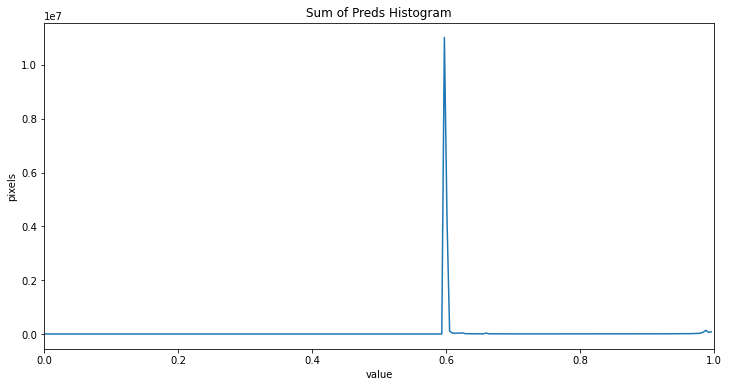

In [61]:
# plot sum of preds histogram
histogram, bin_edges = np.histogram(sum_preds, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Sum of Preds Histogram")
plt.xlabel("value")
plt.ylabel("pixels")
plt.xlim(0.0, 1.0)


#### Get binary preds

In [22]:
from skimage.filters import threshold_otsu

t_otsu = threshold_otsu(sum_preds)
print("Events detection threshold:",t_otsu)

Events detection threshold: 0.77835023


In [23]:
binary_sum_preds = sum_preds > t_otsu

#### Get connected components in sum of all preds

In [45]:
connectivity=26
ccs_events, n_ccs_events = cc3d.connected_components(binary_sum_preds,
                                                     connectivity=connectivity,
                                                     return_N=True
                                                    )
# much faster than ndi.label

In [27]:
print("Number of detected events:", n_ccs_events)

Number of detected events: 121


In [30]:
viewer = napari.Viewer()
viewer.add_image(sample['xs'], 
                 name='movie', 
                 colormap=('colors',cmap)
                )

viewer.add_image(sum_preds,
                 name='sum of preds'
                 )

viewer.add_labels(binary_sum_preds,
                  name='binary sum of preds',
                  opacity=0.5,
                  visible=False
                 )

viewer.add_labels(ccs_events,
                  name='predicted separated events',
                  opacity=0.5
                 )

<Labels layer 'predicted separated events' at 0x2214a6ce1c0>

#### Get argmax class in binary predictions

Select argmax class inside binary prediction mask

In [31]:
from metrics_tools import get_argmax_segmented_output

In [32]:
# get mask containing network output for each class in binary preds
masked_class_preds = binary_sum_preds * [preds['background'], preds['sparks'], preds['waves'], preds['puffs']]

In [33]:
# get argmax of classes inside binary preds
# argmax_preds is a dict with keys 'sparks', 'waves' and 'puffs'
argmax_preds, classes_preds = get_argmax_segmented_output(preds=masked_class_preds,
                                                          get_classes=True)

In [64]:
viewer = napari.Viewer()
viewer.add_image(sample['xs'], 
                 name='movie', 
                 colormap=('colors',cmap)
                )

viewer.add_labels(sample['ys'],
                  name='annotated class of events',
                  opacity=0.5
                 )

viewer.add_labels(classes_preds,
                  name='class of predicted events',
                  opacity=0.5
                 )

<Labels layer 'class of predicted events' at 0x2217a6bd760>

#### Get connected components for each class

In [47]:
# separate CCs in each class
connectivity = 26
   
ccs_class_preds = {class_name: cc3d.connected_components(class_argmax_preds,
                                                         connectivity=connectivity,
                                                         return_N=False
                                                        )
                  for class_name, class_argmax_preds in argmax_preds.items()}

In [49]:
viewer = napari.Viewer()
viewer.add_image(sample['xs'], 
                 name='movie', 
                 colormap=('colors',cmap)
                )

for class_name, class_events in ccs_class_preds.items():
    viewer.add_labels(class_events,
                      name=class_name,
                      opacity=0.5
                     )

#### Watershed separation of spark preds

Only separate spark preds.

Using directly the argmax prediction of the sparks class.

In [65]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

In [66]:
# compute distance from border of binary mask
distances = ndi.distance_transform_edt(argmax_preds['sparks'])

In [86]:
# use peaks of distance metrics to select spark centres
coords = peak_local_max(distances,
                        footprint=np.ones((3, 3, 3)),
                        labels=argmax_preds['sparks'])

mask = np.zeros(distances.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)

split_event_mask = watershed(image=argmax_preds['sparks'],
                             markers=markers,
                             mask=argmax_preds['sparks'],
                             #markers=n_sparks
                            )

In [85]:
# apply watershed using distance matrix minima
split_event_mask = watershed(image=-distances,
                             mask=argmax_preds['sparks'],
                             #markers=n_sparks
                            )

In [87]:
# use peaks of distance metrics to select spark centres and spark preds as input
coords = peak_local_max(distances,
                        footprint=np.ones((3, 3, 3)),
                        labels=argmax_preds['sparks'])

mask = np.zeros(distances.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)

split_event_mask = watershed(image=preds['sparks'],
                             markers=markers,
                             mask=argmax_preds['sparks'],
                             #markers=n_sparks
                            )

In [88]:
clip_distances = np.where(distances>0, distances, 0)

In [89]:
viewer = napari.Viewer()
viewer.add_image(sample['xs'], 
                 name='movie', 
                 colormap=('colors',cmap)
                )

viewer.add_labels(argmax_preds['sparks'],
                  name='binary spark preds',
                  opacity=0.5,
                  visible=False
                 )

viewer.add_image(clip_distances,
                 name='distances from sparks borders',
                 visible=False
                 )

viewer.add_labels(split_event_mask,
                  name='split sparks',
                  opacity=0.5
                 )

<Labels layer 'split sparks' at 0x2214ae34f40>